In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

from sklearn.preprocessing import Imputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel, RFE
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import VarianceThreshold
import seaborn as sns
from sklearn.model_selection import train_test_split

import torch
import torchvision.transforms as transforms
from torch.autograd import Variable
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torch import nn, optim
import torch.nn.init as init
import torch.utils.data as Data
import math


import matplotlib.pyplot as plt
import torch.multiprocessing as mp


In [2]:
mp.set_start_method('spawn')

## hyperparameters

In [3]:
batch_size = 256
#epochs = 2000
use_gpu = True
lr = 0.001
weight_decay = 10

# Batch size and learning rate is hyperparameters in deep learning
# suggest batch_size is reduced, lr is also reduced which will reduce concussion

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [5]:
X = pd.read_csv('./dataset-0510/train.csv')
X_test = pd.read_csv('./dataset-0510/test.csv')

In [6]:
y = X['total_price']
X = X.drop(columns=['building_id', 'total_price'], axis=1)

X_test = X_test.drop(columns=['building_id'], axis=1)

In [7]:
X_train, X_eval, y_train, y_eval = train_test_split(X, y, test_size=0.3, random_state=42) 

### scale y

In [8]:
y_scaler = StandardScaler()
y_train = y_scaler.fit_transform(y_train.values.reshape(-1, 1))
y_eval = y_scaler.fit_transform(y_eval.values.reshape(-1, 1))

## Imputer, Scaler, Feature selection

In [9]:
# step1. Imputation transformer for completing missing values.
step1 = ('Imputer', Imputer())
# step2. MinMaxScaler
step2 = ('MinMaxScaler', MinMaxScaler())
# step3. feature selection
#step3 = ('FeatureSelection', SelectFromModel(RandomForestRegressor()))
step3 = ('FeatureSelection', VarianceThreshold())

pipeline = Pipeline(steps=[step1, step2])



/home/islab/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


In [10]:
print(X_train.shape)
X_train = pipeline.fit_transform(X_train)
X_eval = pipeline.fit_transform(X_eval)

print(X_test.shape)
X_test = pipeline.fit_transform(X_test)


(42000, 233)
(10000, 233)


In [11]:
X_train = torch.from_numpy(X_train).float().to(device)
X_eval = torch.from_numpy(X_eval).float().to(device)

y_train = torch.from_numpy(y_train).float().to(device)
y_eval = torch.from_numpy(y_eval).float().to(device)

X_test = torch.from_numpy(X_test).float().to(device)

In [12]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)

torch.Size([42000, 233])
torch.Size([10000, 233])
torch.Size([42000, 1])


In [13]:
train_dataset = Data.TensorDataset(X_train, y_train)
train_loader = Data.DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=0,
)

eval_dataset = Data.TensorDataset(X_eval, y_eval)
eval_loader = Data.DataLoader(
    dataset=eval_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=0,
)

## building model

In [14]:
class DNN(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.fc1 = nn.Linear(233, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 64)
        self.fc5 = nn.Linear(64, 1)
        
        self.bn = nn.BatchNorm1d(256)
        self.dropout = nn.Dropout(p=0.5)
    def forward(self, x):
        #x = x.unsqueeze(0)
        
        x = self.fc1(x)
        x = self.dropout(x)
        x = F.relu(x)
        
        x = self.fc2(x)
        x = self.dropout(x)
        x = F.relu(x)
        
        x = self.fc3(x)
        x = self.dropout(x)
        x = F.relu(x)
        
        x = self.fc4(x)
        x = self.dropout(x)
        x = F.relu(x)
        
        x = self.fc5(x)
        
        return x

In [15]:
model = DNN().to(device)
criterion = nn.MSELoss()
optim = optim.Adam(model.parameters(), lr= lr)

In [16]:

def train_func(model, loader):
    model.train()
    train_loss = []
    for step, (batch_x, batch_y) in enumerate(loader):
        optim.zero_grad()
        pred = model(batch_x)
        loss = criterion(batch_y, pred)
        loss.backward()
        optim.step()

        train_loss.append(loss.item())
        
    print('training loss', np.array(train_loss).mean())
    return model,  np.array(train_loss).mean()


'''
def train_func(model, loader, accumlation_steps=32):
    model.train()
    optim.zero_grad()
    train_loss = []
    for step, (batch_x, batch_y) in enumerate(loader):
        pred = model(batch_x)
        loss = criterion(pred, batch_y)
        
        train_loss.append(loss.item())
        
        loss = loss / accumlation_steps
        loss.backward()
        
        if step % accumlation_steps == 0 or step == len(loader)-1:
            optim.step()
            optim.zero_grad()

    print('training loss', np.array(train_loss).mean())
    return model, np.array(train_loss).mean()
'''
'''
Batch update
'''
'''
def train_func(model, loader, accumlation_steps=64):
    model.train()
    optim.zero_grad()
    train_loss = []
    loss = 0
    for step, (batch_x, batch_y) in enumerate(loader):
        pred = model(batch_x)
        current_loss = criterion(pred, batch_y)
        loss = loss + current_loss
        train_loss.append(current_loss.item())
        if (step+1) % accumlation_steps == 0 or (step+1) == len(loader):
            optim.zero_grad()
            loss.backward()
            optim.step()
            loss = 0
            
    print('training loss', np.array(train_loss).mean())
    return model, np.array(train_loss).mean()
'''

def eval_func(model, loader):
    model.eval()
    with torch.no_grad():
        for step, (batch_x, batch_y) in enumerate(loader):
            pred = model(batch_x)
            loss = criterion(pred, batch_y)
        print('testing loss', loss.item())
    return loss

def test_func(model, X, y_scaler=None):
    model.eval()
    
    with torch.no_grad():
        pred = model(X)
        pred = pred.cpu().numpy()
        
        if y_scaler != None:
            pred = y_scaler.inverse_transform(pred)
    return pred
    

In [17]:
train_losses = []
eval_losses = []
for t in range(1000):
    print('epochs', t)
    model, train_loss = train_func(model, train_loader)
    if (t+1) % 10 == 0:
        eval_loss = eval_func(model, eval_loader)
        eval_losses.append(eval_loss)
    
    train_losses.append(train_loss)
    

epochs 0
training loss 0.93020822916067
epochs 1
training loss 0.8572185900965423
epochs 2
training loss 0.8274747641362024
epochs 3
training loss 0.828386988626285
epochs 4
training loss 0.7928847277141882
epochs 5
training loss 0.8039446774079945
epochs 6
training loss 0.7743265036154877
epochs 7
training loss 0.6557754843636896
epochs 8
training loss 0.6567168574215788
epochs 9
training loss 0.5303559597017187
testing loss 19.048107147216797
epochs 10
training loss 0.640576097278884
epochs 11
training loss 0.4387501776444189
epochs 12
training loss 0.45047831157165946
epochs 13
training loss 0.5091275434715278
epochs 14
training loss 0.3880476025920926
epochs 15
training loss 0.38850281861695374
epochs 16
training loss 0.4805686870759184
epochs 17
training loss 0.316624829737526
epochs 18
training loss 0.2768256778292584
epochs 19
training loss 0.3874924999181971
testing loss 1.3331897258758545
epochs 20
training loss 0.7190914598604043
epochs 21
training loss 0.6603468568148938
epo

training loss 0.0926595084538514
epochs 176
training loss 0.23346280795380925
epochs 177
training loss 0.10723853559430802
epochs 178
training loss 0.12409669857923732
epochs 179
training loss 0.09074692801769936
testing loss 29.3555965423584
epochs 180
training loss 0.10617237369896787
epochs 181
training loss 0.13687858148054644
epochs 182
training loss 0.11795373074710369
epochs 183
training loss 0.16942654486858483
epochs 184
training loss 0.12254791421194872
epochs 185
training loss 0.12507031717986772
epochs 186
training loss 0.16717879371435354
epochs 187
training loss 0.13136559404207
epochs 188
training loss 0.0908263798520872
epochs 189
training loss 0.10381995538306056
testing loss 17.663774490356445
epochs 190
training loss 0.14017294359703858
epochs 191
training loss 0.10660759552071492
epochs 192
training loss 0.08960509308134064
epochs 193
training loss 0.15480280168580288
epochs 194
training loss 0.11908821217489965
epochs 195
training loss 0.4491697290630052
epochs 196

training loss 0.07001349157794859
epochs 347
training loss 0.18361439176581124
epochs 348
training loss 0.11657604632729834
epochs 349
training loss 0.12359118844297799
testing loss 1.8447048664093018
epochs 350
training loss 0.13518849914385514
epochs 351
training loss 0.11353033838624305
epochs 352
training loss 0.0712278132580898
epochs 353
training loss 0.11358088791144616
epochs 354
training loss 0.126868484812704
epochs 355
training loss 0.07383834454372074
epochs 356
training loss 0.10159628829269698
epochs 357
training loss 0.11878924800478148
epochs 358
training loss 0.10869068843735889
epochs 359
training loss 0.05616958929282246
testing loss 1.1306426525115967
epochs 360
training loss 0.08073424421476595
epochs 361
training loss 0.1011484033004804
epochs 362
training loss 0.10424316315488381
epochs 363
training loss 0.082348351084599
epochs 364
training loss 0.08752780523941373
epochs 365
training loss 0.07916624945108637
epochs 366
training loss 0.10853231282848301
epochs 3

training loss 0.054090303295489514
epochs 518
training loss 0.05252608498840621
epochs 519
training loss 0.09562161665861353
testing loss 2.8701202869415283
epochs 520
training loss 0.07386016715882403
epochs 521
training loss 0.05264370014157259
epochs 522
training loss 0.0781854296328895
epochs 523
training loss 0.15704023799096997
epochs 524
training loss 0.12717826467458948
epochs 525
training loss 0.08323739608467529
epochs 526
training loss 0.0701439692779924
epochs 527
training loss 0.10698135578158227
epochs 528
training loss 0.06318515154787085
epochs 529
training loss 0.0766043510570219
testing loss 0.5576624870300293
epochs 530
training loss 0.05853111364060279
epochs 531
training loss 0.042426218860077136
epochs 532
training loss 0.10582277405668389
epochs 533
training loss 0.07698486262763088
epochs 534
training loss 0.05968431583746816
epochs 535
training loss 0.15979906134307384
epochs 536
training loss 0.07349501700338089
epochs 537
training loss 0.05948723997130539
epo

training loss 0.059418663128533146
epochs 689
training loss 0.04607468771776466
testing loss 0.4730655550956726
epochs 690
training loss 0.06614670719612728
epochs 691
training loss 0.09487391258731033
epochs 692
training loss 0.07000437851882342
epochs 693
training loss 0.06410812849574017
epochs 694
training loss 0.09828394846708485
epochs 695
training loss 0.16623827563316534
epochs 696
training loss 0.0598410384898836
epochs 697
training loss 0.08905334904451262
epochs 698
training loss 0.05703169446099888
epochs 699
training loss 0.07499812313948165
testing loss 1.783929467201233
epochs 700
training loss 0.05278090025213632
epochs 701
training loss 0.054102830808948385
epochs 702
training loss 0.04787188247975075
epochs 703
training loss 0.04460826298842827
epochs 704
training loss 0.10992469126640847
epochs 705
training loss 0.09039141618731347
epochs 706
training loss 0.04305026949467984
epochs 707
training loss 0.058116761397457486
epochs 708
training loss 0.057390307025475935


training loss 0.0542304264889522
epochs 859
training loss 0.08619357129615364
testing loss 1.3284406661987305
epochs 860
training loss 0.04998269865119999
epochs 861
training loss 0.06772873545009078
epochs 862
training loss 0.1287269619039514
epochs 863
training loss 0.09902299573137001
epochs 864
training loss 0.06006200625702287
epochs 865
training loss 0.06012415586208755
epochs 866
training loss 0.06881139911146777
epochs 867
training loss 0.07448522213169119
epochs 868
training loss 0.03592738715762442
epochs 869
training loss 0.07237736601382494
testing loss 1.4012528657913208
epochs 870
training loss 0.04857116345259728
epochs 871
training loss 0.07670658297949669
epochs 872
training loss 0.04836277516953873
epochs 873
training loss 0.05503837508008336
epochs 874
training loss 0.060651858879083934
epochs 875
training loss 0.07291520633029215
epochs 876
training loss 0.1135855730284344
epochs 877
training loss 0.06798847793516788
epochs 878
training loss 0.03800192592157559
epoc

## overfitting

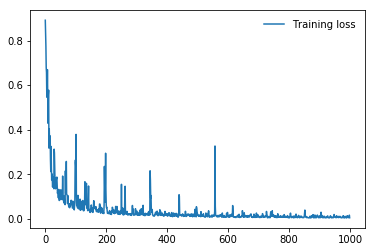

In [18]:
plt.plot(train_losses, label='Training loss')
plt.legend(frameon=False)

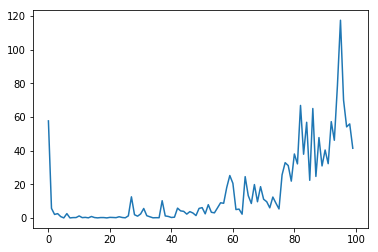

In [19]:
plt.plot(eval_losses, label='Validation loss')


## overfitting2

In [ ]:
plt.plot(train_losses, label='Training loss')
plt.legend(frameon=False)

In [ ]:
plt.plot(eval_losses, label='Validation loss')


## vaildation

In [21]:
eval_func(model, eval_loader)

testing loss 36.94070053100586


tensor(36.9407, device='cuda:0')

### Submission

In [22]:
pred = test_func(model, X_test, y_scaler)
pred

array([[ 7.8621939e+08],
       [ 7.2142335e+06],
       [ 1.1949832e+07],
       ...,
       [-9.6227256e+05],
       [ 2.3039574e+08],
       [ 8.8473740e+06]], dtype=float32)

In [23]:

submission = pd.read_csv('./dataset-0510/submit_test.csv')
submission['total_price'] = pred
submission.to_csv('submission/DNN2_result.csv', index=False)

### test result

Batch size use 128 or 32 , learning rate use 0.003 which find loss will stock in 0.6

Result 1 DNN 233->256->128->1, lr=0.001, batch_size=128, predict score : 13
change: 
- replacing Standard to MinMax 
- adding DropOut 0.3 layer
- batch size change to 512